In [1]:
# initial setup
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

In [2]:
# python standard library
import bisect
import gc
import pickle
import multiprocessing as mp

gc.enable()

In [3]:
# third-party modules
from collections import defaultdict, OrderedDict
from joblib import Parallel, delayed
import igraph as ig
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%aimport matplotlib.font_manager
import numpy as np
import pandas as pd
import psutil
import scipy.stats as sps
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm_notebook

%matplotlib inline

In [4]:
# custom modules
%aimport util
%aimport qtls
%aimport networks
%autosave 15

Autosaving every 15 seconds


In [315]:
# data loaders

qtls_df = {
    "eQTLs_2018" : { 
        "A&B" : pd.read_table("./data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2018/qtls_limix.csv")
    }, 
}
scaler_df = {
    "eQTLs_2018" : {
        "A&B" : MinMaxScaler()
    }
}
qtls_df["eQTLs_2018"]["A&B"]["score"] = (1 - scaler_df["eQTLs_2018"]["A&B"]\
                                               .fit_transform(
                                                    qtls_df["eQTLs_2018"]["A&B"]["LOD"].values[:,None]
                                                )
                                          )
qtls_df["eQTLs_2018"]["limix"]["score"] = qtls_df["eQTLs_2018"]["limix"]["q_value"]

# Physical and genetic interactions taken from TheBioGrid project
interactome_df = pd.read_table("./data/raw/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association", 
    "colocalization", 
    "direct interaction",
    "physical association"
]

interactome_df.set_index('Interaction Type', inplace=True)

genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

interaction_categories = (genetic_interaction_categories 
                          + physical_interaction_categories 
                          + ["all", "physical", "genetic"])

def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

type2interactome = {}
for edge_type in interaction_categories:
    with open("./data/raw/interactions/{}_interactions_graph.pkl".format(edge_type), "rb") as infile:
        type2interactome[edge_type] = pickle.load(infile)

category = {"all" : "all"}
for edge_type in physical_interaction_categories + ["physical"]:
    category[edge_type] = "physical"
for edge_type in genetic_interaction_categories + ["genetic"]:
    category[edge_type] = "genetic"

with open("./data/raw/genomic_features/chromosome_endpoints.pkl","rb") as pickle_file:
    chromosome_endpoints = pickle.load(pickle_file)
chromosome_labels = [util.as_roman(n) for n in np.arange(1, 17)]

# Goals

In this section we aim to:

0. Learn more about the hotspots in yeast genome. What's the biological function of the most evident hotspots?
1. Find out whether the interacting genes tend to share linkages if markers are located in particular hotspot.
   What about genes that are not affected by any hotspots?
2. Analyze the hotspots with the strongest signal. What makes them special? What common features do they share? Albert and Bloom spent a lot of time researching this issue, we can simply reproduce their results.

# Exploring the hotspot dataset

Albert and Bloom detected 102 eQTL hotspots using an algorithm of their own invention.

## Legend

- **hotspotMarker** —	Position of the hotspot based on initial scan for hotspots (prior to bootstrapping). This string can be used to cross-reference between this table and the various other hotspot-centric result tables
- **chromosome** —	The chromosome on which the hotspot is located
- **bootstrapPeak** —	Median bootstrap position
- **bootstrapIntervalLeft** —	95% bootstrap confidence interval of hotspot location – left marker
- **bootstrapIntervalRight** —	95% bootstrap confidence interval of hotspot location – right marker
- **boostrapIntervalWidth** —	bootstrapIntervalRight minus bootstrapIntervalLeft
- **numberGenesInHotspot** —	Number of genes that overlap the hotspot location interval
- **numberEQTLInHotspot** —	Number of eQTL with confidence intervals that overlap the hotspot
- **numberNonzeroEffects** —	Number of genes with non-zero effects when fitting hotspot effects

In [8]:
hotspot_df = pd.read_csv("data/raw/eQTLs/2018/hotspots.csv", sep='\t')
hotspot_df.sort_values(by="boostrapIntervalWidth", ascending=False).head()

,hotspotMarker,chromosome,bootstrapPeak,bootstrapIntervalLeft,bootstrapIntervalRight,boostrapIntervalWidth,numberGenesInHotspot,numberEQTLInHotspot,numberNonzeroEffects
28,chrV:183957_A/G,chrV,183957,137820,196986,59166,38,283,438
18,chrIV:461656_A/G,chrIV,452236,414243,464571,50328,34,1020,846
56,chrX:426287_C/A,chrX,429703,416411,455247,38836,24,261,276
22,chrIV:745766_G/A,chrIV,745766,728918,759809,30891,15,810,511
37,chrVII:178509_T/C,chrVII,194505,174975,205155,30180,19,1669,1109


In [369]:
hotspot_df[["boostrapIntervalWidth", "numberGenesInHotspot", "numberEQTLInHotspot"]].describe()

,boostrapIntervalWidth,numberGenesInHotspot,numberEQTLInHotspot
count,102.000000,102.000000,102.000000
mean,10596.519608,7.401961,539.696078
std,11290.767253,6.846637,728.026694
min,0.000000,1.000000,7.000000
25%,2933.500000,3.000000,84.000000
50%,5858.000000,5.000000,272.000000
75%,15682.250000,10.000000,703.000000
max,59166.000000,38.000000,3802.000000


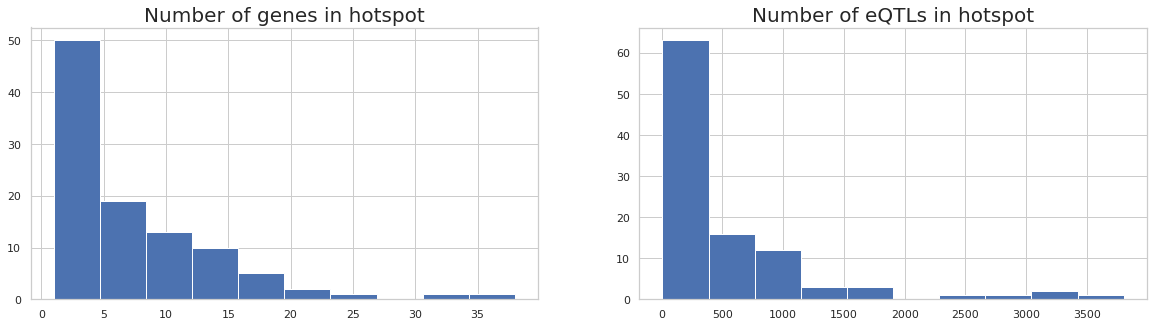

In [349]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].set_title("Number of genes in hotspot", fontsize=20)
axes[0].hist(hotspot_df.numberGenesInHotspot);
axes[1].set_title("Number of eQTLs in hotspot", fontsize=20)
axes[1].hist(hotspot_df.numberEQTLInHotspot);

- **Nearly a half of hotspots contain only one gene or no genes at all.**  
- **Hotspots have 540 associated eQTLs on average (with a median value of 272 — right tail of the distribution is heavy).**  
  **79/102 ($\approx 75\%$) of hotspots have less than 387 and only 11 hotspots have more than 766.**
- Not sure about the interval width summary: is a mean value of 10596 large or small?

What worries me is a **discrepancy between my analysis results and their figure**. They say:

> The 102 hotspots affected a median of 425 genes, ranging from 26 (a newly discovered hotspot at position 166,390 bp on chromosome III) to 4594 at the previously reported MKT1 hotspot (Zhu et al., 2008) (82% of 5629 genes with any signal at a hotspot; Figure 3B). Three additional hotspots each affected more than half of all genes. They include a previously described hotspot at the HAP1 gene (Brem et al., 2002) (3640 genes affected), as well as two newly detected hotspots on chromosome XIV. A hotspot at 372,376 bp affected 4172 genes and is likely caused by a variant that recently arose in the KRE33 gene in the RM parent used in our cross (Jerison et al., 2017). A hotspot at position 267,161 bp affected 3169 genes and spans the genes GCR2, YNL198C, WHI3 and SLZ1. These results indicate that hotspots can have extraordinarily wide-reaching effects on the transcriptome, with some influencing the expression of the majority of all genes.

While we can see, that no hotspot can affect more than 3802 genes (and that's weird, because I downloaded the data directly from their supplementary materials).  

In [392]:
class HotspotPlotter:
    def __init__(self, qtl_df, qtl_type, figsize, title, fig=None, ax=None):
        sns.set(style="whitegrid")
        if fig is None or ax is None:
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else: 
            self.fig, self.ax = fig, ax
        self.ax.set_title(
            title,
            fontsize=30
        )        
        self.ax.set_xlabel("marker position (chromosome)", fontsize=25)
        self.ax.set_ylabel("number of affected genes", fontsize=25)
        
        self.qtl_df = qtl_df
        self.qtl_type = qtl_type
        
        with open("./data/raw/genomic_features/order_of_markers.pkl", "rb") as pickle_file:
            self.marker2location = pickle.load(pickle_file)
        with open("./data/raw/genomic_features/chromosome_endpoints.pkl","rb") as pickle_file:
            self.chromosome_endpoints = pickle.load(pickle_file)
        self.chromosome_labels = [util.as_roman(n) for n in np.arange(1, 17)]
        
        self.ax.set_xticks(self.chromosome_endpoints)
        self.ax.set_xticklabels(self.chromosome_labels)
        self.ax.tick_params(axis='both', which='major', labelsize=20)
        self.ax.tick_params(axis='both', which='minor', labelsize=20)
        self.ax.grid(linestyle="dotted")
        
        # plt.savefig("img/qtl_distributions/corrected_limix_vs_A&B_2018.png", dpi=300)
#         plt.show()
#         plt.close()
        
    def _base_plot(self):
        for i in range(1, 17):
            self.ax.axvline(
                x=self.chromosome_endpoints[i - 1], 
                linestyle='--', 
                color='grey', 
                alpha=0.8
            )
            
        QTL_markers, self.QTL_y = qtls.linkages2gencoords(self.qtl_df)
        self.QTL_x = [self.marker2location[m] for m in QTL_markers]
        
        self.ax.plot(
            self.QTL_x,
            self.QTL_y,
            label="{}, {} QTLs".format(self.qtl_type, self.qtl_df.shape[0]),
            alpha=1,
            color="green",
            zorder=1
        )

        self.ax.fill_between(
            self.QTL_x, 0, 
            self.QTL_y, 
            alpha=0.7, 
            color="green"
        )
        
    def distplot(self, hotspot_intervals):
        self._base_plot()
        for l, r in hotspot_intervals:
            l_id = bisect.bisect_left(self.QTL_x, l)
            r_id = bisect.bisect_right(self.QTL_x, r)
            assert l_id <= r_id
            if r_id - l_id + 1 >= 5:
                self.ax.plot(
                    self.QTL_x[l_id:r_id+1], 
                    self.QTL_y[l_id:r_id+1], 
                    color="red"
                )
                self.ax.fill_between(
                    self.QTL_x[l_id:r_id+1], 0, 
                    self.QTL_y[l_id:r_id+1], 
                    alpha=0.7, color="red"
                )
#             else: 
            self.ax.axvline(l, color="r", linestyle="--", alpha=0.2)
            self.ax.axvline(r, color="r",  linestyle="--", alpha=0.2)

90% the trans-acting eQTLs are clustered in hotspots. To see that, let's visualize the correspondence between gene and marker coordinates in linkages.

No handles with labels found to put in legend.


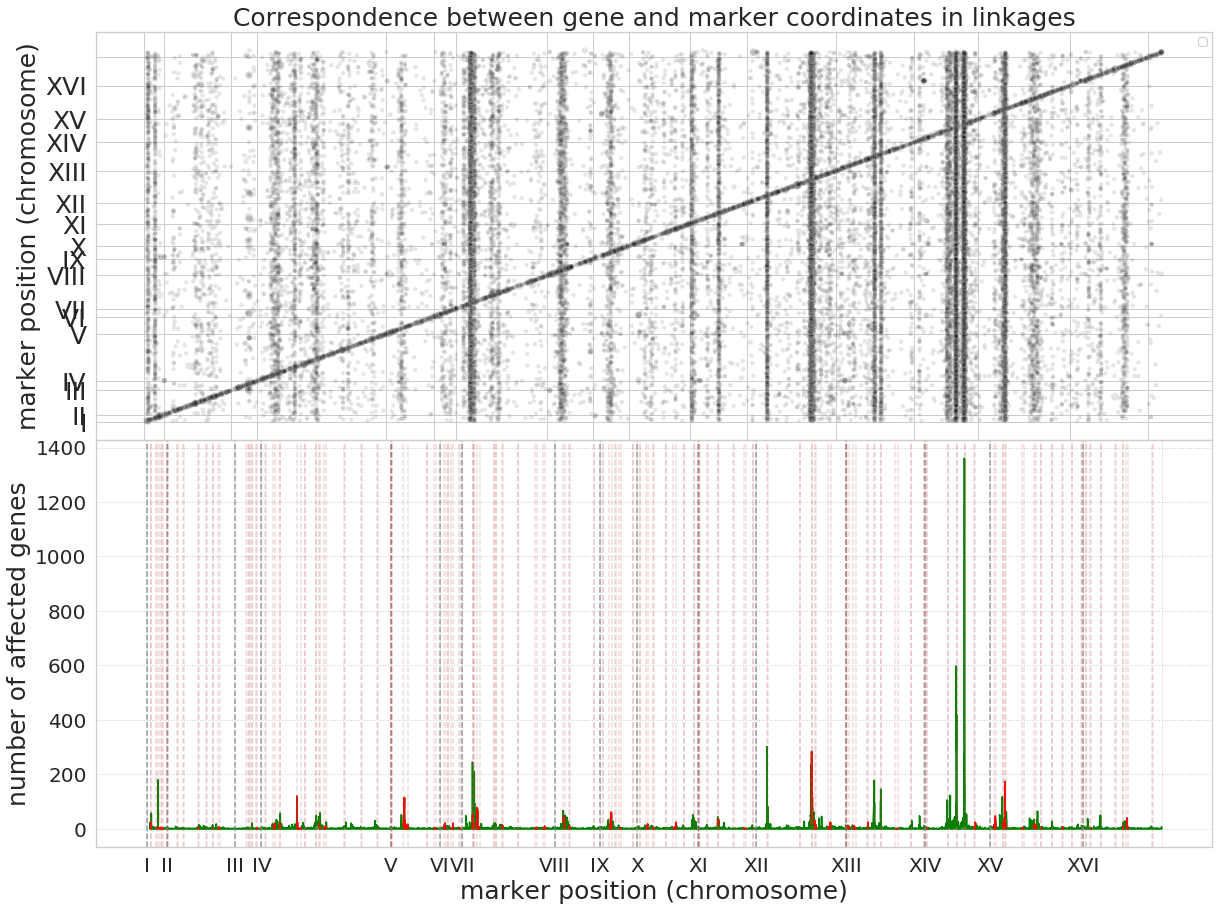

In [464]:
# plot the hotspot distribution across genome

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 1, fig, hspace=0)
axes = [plt.subplot(gs[i]) for i in range(2)]

axes[0].set_title("Correspondence between gene and marker coordinates in linkages", fontsize=25)
sns.scatterplot(
    x="markerPlotCoordinate", 
    y="genePlotCoordinate", 
    color="black",
    size="var.exp",
    data=qtls_df["eQTLs_2018"]["A&B"], 
    alpha=0.1,
    ax=axes[0],
    legend=False
);
axes[0].set_xlabel("gene position (chromosome)", fontsize=25)
axes[0].set_ylabel("marker position (chromosome)", fontsize=25)
axes[0].set_xticks(chromosome_endpoints);
axes[0].set_xticklabels(chromosome_labels)
axes[0].set_yticks(chromosome_endpoints);
axes[0].set_yticklabels(chromosome_labels);
axes[0].tick_params(labelsize=25)
axes[0].legend(framealpha=1.);

plotter = HotspotPlotter(figsize=(30,10), 
                         qtl_df=qtls_df["eQTLs_2018"]["A&B"], 
                         qtl_type="eQTLs_2018", 
                         title="",#"eQTLs from 'Genetics of trans-regulatory variation in gene expression' (eLife, 2018)", 
                         ax=axes[1], 
                         fig=fig)
hotspot_intervals = []
for chr_name, l, r in hotspot_df[["chromosome", "bootstrapIntervalLeft", "bootstrapIntervalRight"]].values:
    offset = plotter.chromosome_endpoints[util.as_arabic(chr_name[3:])-1]
    if offset is None: pass
    hotspot_intervals.append([l + offset, r + offset])
hotspot_intervals = np.vstack(hotspot_intervals)
plotter.distplot(hotspot_intervals)

Let's visualize how many eQTLs are affected by hotspots:

In [370]:
# convert confidence interval bounds to explicit genetic coordinates
chromosome_endpoints = plotter.chromosome_endpoints
def marker_to_coord(marker):
    chr_name, rest = marker.split(":")
    offset = int(rest.split("_")[0])
    return offset + chromosome_endpoints[util.as_arabic(chr_name[3:]) - 1]

qtls_df["eQTLs_2018"]["A&B"]["CI.lpos"] = qtls_df["eQTLs_2018"]["A&B"]["CI.l"].apply(marker_to_coord)
qtls_df["eQTLs_2018"]["A&B"]["CI.rpos"] = qtls_df["eQTLs_2018"]["A&B"]["CI.r"].apply(marker_to_coord)

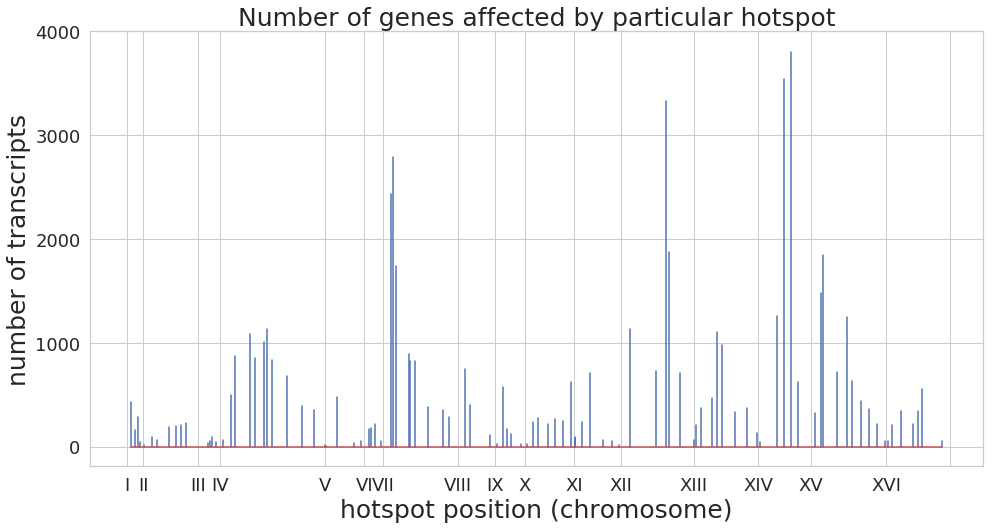

In [385]:
# plot the distribution of the number of genes affected by hotspots
interactome = "physical"
df = qtls_df["eQTLs_2018"]["A&B"]
pts = []

for l, r in tqdm_notebook(hotspot_intervals, "hotspot"):
    hotspot_qtls_df = df[df["CI.rpos"].apply(lambda x: min(x, r)) 
                         - df["CI.lpos"].apply(lambda x: max(x, l)) >= 0]
    if hotspot_qtls_df.shape[0] == 0: 
        simulation_results.append([np.nan, np.nan])
        continue
    pts.append([(l + r) / 2, hotspot_qtls_df.shape[0]])    

pts = sorted(pts, key=lambda p:p[0])
pts = np.vstack(pts)
plt.figure(figsize=(16,8))
plt.title("Number of genes affected by particular hotspot", fontsize=25);
plt.stem(pts[:, 0], pts[:, 1], markerfmt=" ");
plt.yticks([0, 1000, 2000, 3000, 4000]);
plt.ylabel("number of transcripts", fontsize=25);
plt.xticks(chromosome_endpoints, [util.as_roman(n) for n in range(1, 17)]);
plt.xlabel("hotspot position (chromosome)", fontsize=25);
plt.tick_params(labelsize=18);

That's very close to the figure Albert and Bloom give in their paper (but less eQTLs are affected).

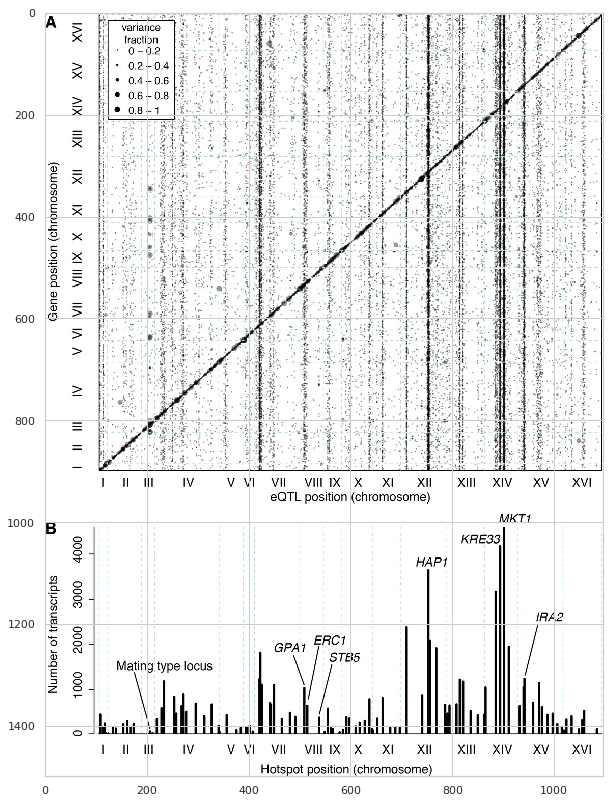

In [454]:
plt.figure(figsize=(10,20))
plt.imshow(plt.imread("img/albert_bloom/figure_3.jpg"));

Let's run the tests on their data to find out to which extent do interacting genes affected by hotspots tend to share linkages.

In [374]:
# run the "randomized interactome test" on each hostpot
def hotspot_handler(hotspot_interval):
    l, r = hotspot_interval
    rptest = qtls.RandomizedInteractomeTest(
        type2interactome["physical"], 
        "physical",
        df[df["CI.rpos"].apply(lambda x: min(x, r)) 
           - df["CI.lpos"].apply(lambda x: max(x, l)) >= 0],
        np.atleast_1d(1.),
        "data/raw/randomized_interactome_copies/",
        max_iter=1024, 
        n_jobs=1
    )
    return rptest.map_reduce()

simulation_results = Parallel(n_jobs=-1)(
    delayed(hotspot_handler)(interval)
    for interval in tqdm_notebook(hotspot_intervals, "hotspot")
)

In [410]:
# aggregate the results and show the significant ones
simres_df = pd.DataFrame([(
    hotspot_intervals[i][0], 
    hotspot_intervals[i][1], 
    hotspot_intervals[i][1] - hotspot_intervals[i][0],
    *simulation_results[i]["p-value"],
    *simulation_results[i]["actual"]["linksim"]["mean"],
    *simulation_results[i]["random"]["linksim"]["25%"],
              *simulation_results[i]["random"]["linksim"]["50%"],
    *simulation_results[i]["random"]["linksim"]["75%"]) 
    for i in range(hotspot_intervals.shape[0])], 
    columns=["CI.lpos", "CI.rpos", 
             "width", 
             "p_value",
             "actual_mean",
             "random_1st_quartile", 
             "random_median", 
             "random_3rd_quartile"]
)
simres_df["affected_qtls"] = hotspot_df["numberEQTLInHotspot"]
chr_loc = np.zeros_like(simres_df["width"])
for i, chr_start in enumerate(chromosome_endpoints):
    chr_loc[simres_df["CI.lpos"] >= chr_start] = i + 1
simres_df["chr"] = chr_loc
simres_df["ratio"] = simres_df["actual_mean"] / simres_df["random_median"]
signif_res_df = simres_df.query("(p_value <= 0.05) & (actual_mean > 0) & (ratio < inf)").sort_values("ratio", ascending=False)
signif_res_df[["CI.lpos", "CI.rpos", "p_value", "affected_qtls", "chr", "ratio"]]

,CI.lpos,CI.rpos,p_value,affected_qtls,chr,ratio
25,2700238.0,2709199.0,0.000000e+00,346,4.0,3.516071
61,6566059.0,6573199.0,0.000000e+00,206,11.0,3.376068
45,4950191.0,4956130.0,0.000000e+00,369,8.0,3.225605
73,8277808.0,8307039.0,0.000000e+00,335,13.0,3.085859
10,832605.5,854365.5,0.000000e+00,206,2.0,2.883929
16,1484370.0,1504947.0,0.000000e+00,415,4.0,2.774209
62,6691868.0,6696055.0,0.000000e+00,681,11.0,2.272334
100,11477076.0,11496555.0,0.000000e+00,515,16.0,2.221524
17,1555988.0,1560597.0,0.000000e+00,870,4.0,2.124828
48,5419345.0,5446080.0,0.000000e+00,475,9.0,2.030133


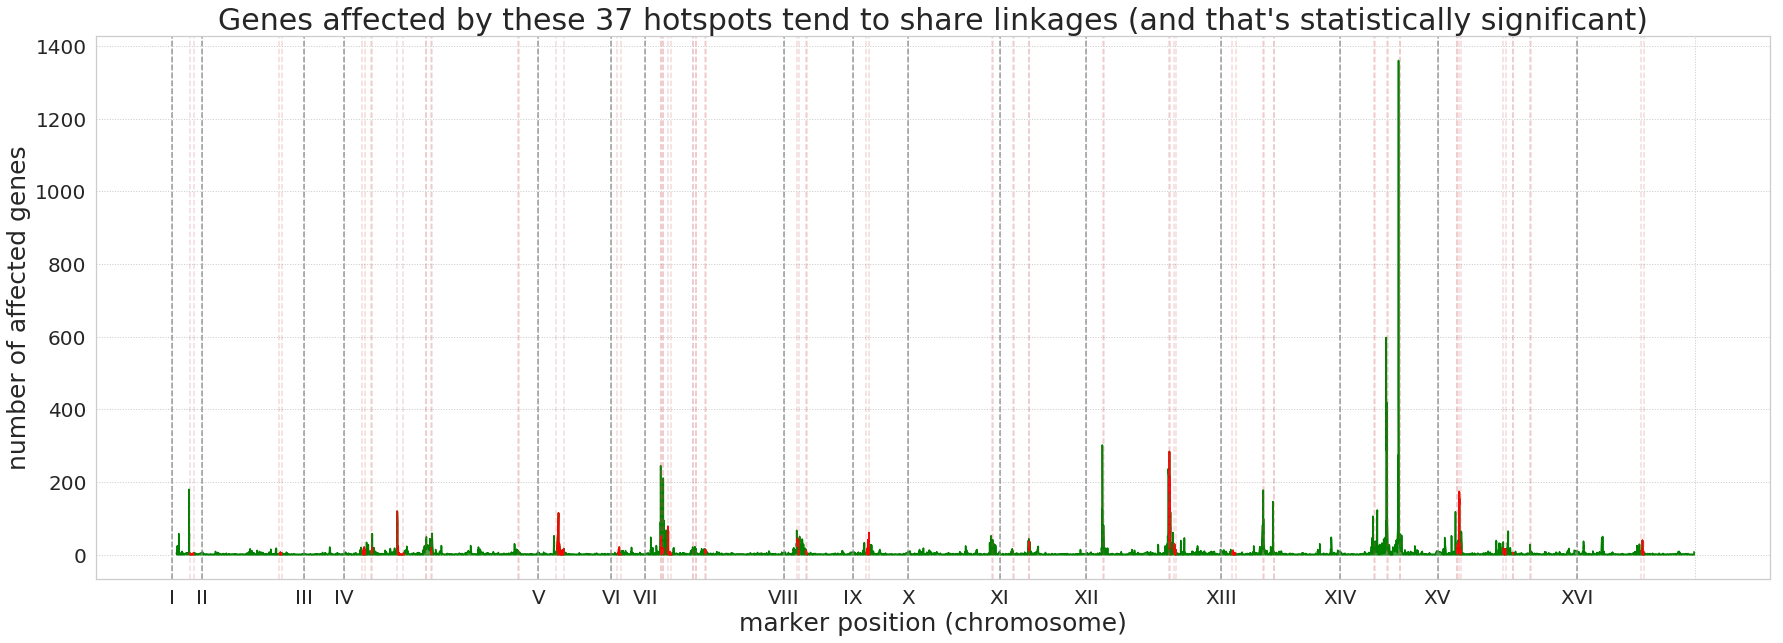

In [461]:
plotter = HotspotPlotter(
    figsize=(30,10), 
    qtl_df=qtls_df["eQTLs_2018"]["A&B"], 
    qtl_type="eQTLs_2018", 
    title="Genes affected by these {} hotspots tend to share linkages (and that's statistically significant)".format(signif_res_df.shape[0])
)
plotter.distplot(signif_res_df[["CI.lpos", "CI.rpos"]].values)

## Conclusions  

1. We can see, that almost all strong hotspots have the desired property. It may be of interest to look closer at the strongest hotspots.
2. Moreover, only three visible hotspots don't agree with our hypothesis. 
3. We can try to derive biological explanation from analysis done in A&B's paper.

# eQTLs not affected by hotspots

First of all, let's count how many eQTLs are not affected by any hotspot.

In [415]:
indices_in_hotspot = []
for l, r in tqdm_notebook(hotspot_intervals, "hotspot"):
    hotspot_qtls_df = df[df["CI.rpos"].apply(lambda x: min(x, r)) 
                         - df["CI.lpos"].apply(lambda x: max(x, l)) >= 0]
    if hotspot_qtls_df.shape[0] == 0: 
        simulation_results.append([np.nan, np.nan])
        continue
    indices_in_hotspot.append(hotspot_qtls_df.index)
indices_in_hotspot = np.hstack(indices_in_hotspot)
not_in_hotspot_df = df[~df.index.isin(indices_in_hotspot)]
not_in_hotspot_df.head()

,gene,SNP,r,LOD,CI.l,CI.r,markerPlotCoordinate,genePlotCoordinate,gene.to.CI.dist,cis,chr,var.exp,lm.coeff,score,CI.lpos,CI.rpos
0,GDH3,chrI:33293_A/T,-0.780048,206.064062,chrI:33040_A/G,chrI:34170_T/A,33293,31567,0.0,1,chrI,0.574708,-0.765508,0.637525,33040.0,34170.0
1,BDH1,chrI:35818_A/G,0.606570,100.811735,chrI:35128_AG/A,chrI:36637_A/G,35818,35155,0.0,1,chrI,0.322080,0.569702,0.824874,35128.0,36637.0
2,GPB2,chrI:39162_C/G,-0.819592,244.787267,chrI:39162_C/G,chrI:39162_C/G,39162,39259,0.0,1,chrI,0.656611,-0.811306,0.568598,39162.0,39162.0
5,AIM2,chrI:52951_G/T,0.883095,332.591545,chrI:52632_T/C,chrI:53167_A/G,52951,51855,0.0,1,chrI,0.729127,0.863904,0.412306,52632.0,53167.0
9,ERV46,chrI:62361_T/C,-0.306750,21.716312,chrI:62361_T/C,chrI:68621_AT/A,62361,61316,0.0,1,chrI,0.047156,-0.258132,0.965664,62361.0,68621.0


In [417]:
not_in_hotspot_df.describe()

,r,LOD,markerPlotCoordinate,genePlotCoordinate,gene.to.CI.dist,cis,var.exp,lm.coeff,score,CI.lpos,CI.rpos
count,4738.000000,4738.000000,4.738000e+03,4.738000e+03,2.081000e+03,4738.000000,4738.000000,4738.000000,4738.000000,4.738000e+03,4.738000e+03
mean,-0.017285,27.789045,6.427151e+06,5.982235e+06,1.936632e+04,0.377797,0.082305,-0.017271,0.954855,6.330295e+06,6.357373e+06
std,0.314745,53.615851,3.323846e+06,3.450007e+06,9.595257e+04,0.484888,0.133633,0.285254,0.095436,3.273965e+06,3.275524e+06
min,-0.948620,2.656117,3.304000e+04,3.156700e+04,0.000000e+00,0.000000,0.000355,-0.946408,0.104110,3.304000e+04,3.417000e+04
25%,-0.203591,4.720121,3.783786e+06,3.018584e+06,0.000000e+00,0.000000,0.015880,-0.174656,0.960992,3.738575e+06,3.755904e+06
50%,-0.121975,8.937244,7.089976e+06,5.920044e+06,0.000000e+00,0.000000,0.029418,-0.091041,0.988411,6.964314e+06,6.983053e+06
75%,0.196203,24.341134,9.509649e+06,8.864404e+06,0.000000e+00,1.000000,0.081814,0.167601,0.995918,9.380199e+06,9.387624e+06
max,0.934664,505.735627,1.205137e+07,1.212023e+07,1.032974e+06,1.000000,0.899374,0.924331,0.999591,1.190091e+07,1.190268e+07


We see the total of 4738 eQTLs not affected by any of the hotspots.  
Let's run the tests:

In [418]:
not_in_hotspot_res = qtls.RandomizedInteractomeTest(
    type2interactome["physical"], 
    "physical",
    not_in_hotspot_df,
    np.atleast_1d(1.),
    "data/raw/randomized_interactome_copies/",
    max_iter=1024, 
    n_jobs=1
).map_reduce()

In [439]:
not_in_hotspot_res

{'actual': {'linksim': {'mean': array([0.00274002])}},
 'p-value': array([0.]),
 'random': {'linksim': {'25%': array([0.00105488]),
   '50%': array([0.00115851]),
   '75%': array([0.00128339])}}}

## Conclusions

If we limit the set of eQTLs to those not affected by any hotspots, we will still see that the interacting genes tend to share linkages (with a ratio of 2.7 distinguishing the real graph from its randomized copies).  
**Observation:** the ratio (actual / random mean linkage similarity) is much higher than for most of the hotspots.